## Libraries

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
##import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.nn import Linear, BCEWithLogitsLoss
from torch.optim import Adam
import gc
import os
import cv2
import time
import warnings
import random
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import Compose, ToTensor, ToPILImage, RandomApply, RandomHorizontalFlip, RandomAffine, RandomErasing, RandomResizedCrop, RandomVerticalFlip, Normalize

warnings.filterwarnings('ignore')

In [4]:
model = torch.load('../output/model.pth')

## Arguments

In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 15
EARLY_PATIENCE = 3
PLATEAU_PATIENCE = 1

## Load data

In [3]:
train_df = pd.read_csv('../input/train.csv')
train_df = train_df[['image_name', 'target']]

train_df.head()

,image_name,target
0,ISIC_2637011,0
1,ISIC_0015719,0
2,ISIC_0052212,0
3,ISIC_0068279,0
4,ISIC_0074268,0


In [4]:
train_df['target'].value_counts() / len(train_df)

0    0.98237
1    0.01763
Name: target, dtype: float64

In [5]:
train_df, test_df = train_test_split(
    train_df,
    stratify = train_df['target'],
    test_size = 0.2,
    shuffle = True,
    random_state = 2020
)

train_df, val_df = train_test_split(
    train_df,
    stratify = train_df['target'],
    test_size = 0.2,
    shuffle = True,
    random_state = 2020   
)

print(f'Train: {train_df.shape}')
print(f'Val: {val_df.shape}')
print(f'Test: {test_df.shape}')

Train: (21200, 2)
Val: (5300, 2)
Test: (6626, 2)


In [6]:
class MelanomaDataset(Dataset):
    def __init__(self, df, labels = True, augmentations = None):
        self.df = df
        self.augmentations = augmentations
        self.labels = labels
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        img_name = self.df.iloc[index]['image_name']
        path = f'../input/images/{img_name}.jpg'
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations is not None:
            img = self.augmentations(img)
            
        if self.labels == True:
            label = self.df.iloc[index]['target']
            return (img, label)
        else:
            return img

In [7]:
# croppaa itse
augs_train = Compose([
    ToPILImage(),
    RandomResizedCrop(size = 256, scale = (0.8, 1.0)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ToTensor(), # also scales to [0, 1]
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

augs_test = Compose([
    ToPILImage(),
    ToTensor(), # also scales to [0, 1]
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [8]:
train_dataset = MelanomaDataset(train_df, augmentations = augs_train)
val_dataset = MelanomaDataset(val_df, augmentations = augs_test)
test_dataset = MelanomaDataset(val_df, augmentations = augs_test)

In [9]:
train_gen = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_gen = DataLoader(val_dataset, batch_size = BATCH_SIZE//2, shuffle = False)
test_gen = DataLoader(test_dataset, batch_size = BATCH_SIZE//2, shuffle = False)

## Visualize data

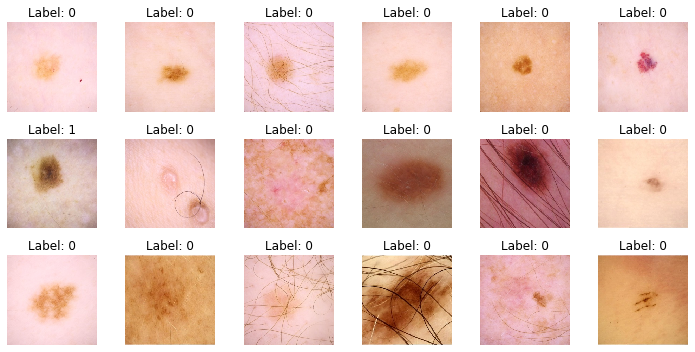

In [10]:
random_img_names = np.random.choice(train_df['image_name'], 18)

fig = plt.figure(figsize = (10, 5))
for i, img_name in enumerate(random_img_names):
    plt.subplot(3, 6, i + 1)
    img = cv2.imread(f'../input/images/{img_name}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    label = train_df['target'].loc[train_df['image_name'] == img_name].values[0]
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()

## Specify model

In [3]:
class EfficientNetB0(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0') 
        self.model._fc = nn.Linear(1280, 1)
        
    def forward(self, x):
        y = self.model(x).view(-1)
        return y

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EfficientNetB0().to(device)
criterion = BCEWithLogitsLoss() # sigmoid layer + BCELoss
optimizer = Adam(model.parameters(), lr = 5e-4, betas = (0.9, 0.999)) #1e-4

scheduler = ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    patience = PLATEAU_PATIENCE,
    factor = 0.2,
    verbose = True
)

Loaded pretrained weights for efficientnet-b0


## Fit model

In [14]:
patience_counter = EARLY_PATIENCE
best_val_loss = 999

for i_epoch in range(NUM_EPOCHS):
    # ------------- Optimization on training data -------------
    train_losses = []
    val_losses = []
    preds_train = []
    labels_train = []
    model.train() # set train mode
    for i_batch, (images, labels) in enumerate(train_gen):
        images = images.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.float32)  
        optimizer.zero_grad() # clear gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        preds_train.extend(torch.sigmoid(outputs.detach()).cpu().numpy())
        labels_train.extend(labels.detach().cpu().numpy())
        
    train_acc = accuracy_score(labels_train, np.round_(preds_train))
    train_auc = roc_auc_score(labels_train, preds_train)    
    
    # ------------- Evaluation on validation data -------------
    preds_val = []
    model.eval() # set evaluation mode
    with torch.no_grad():
        for i_batch, (images, labels) in enumerate(val_gen):
            images = images.to(device, dtype = torch.float32)
            labels = labels.to(device, dtype = torch.float32)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            preds_val.extend(torch.sigmoid(outputs).cpu().numpy())

    val_acc = accuracy_score(val_df['target'].values, np.round_(preds_val))
    val_auc = roc_auc_score(val_df['target'].values, preds_val)    
        
    # ------------- Display progress -------------
    print(f'{i_epoch+1} | Train loss: {np.mean(train_losses):.4f} | Val loss: {np.mean(val_losses):.4f} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f} | Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}')
    
    # ------------- Check learning plateau criterion -------------
    scheduler.step(val_auc)
    
    # ------------- Check early stopping criterion -------------
    curr_val_loss = np.mean(val_losses)
    if curr_val_loss < best_val_loss:
        best_val_loss = curr_val_loss
        # reset patience counter
        patience_counter = EARLY_PATIENCE  
        torch.save(model, '../output/model.pth') # uses pickle
    else:
        patience_counter -= 1
        if patience_counter == 0:
            print('Early stopping')
            break

1 | Train loss: 0.0874 | Val loss: 0.0718 | Train acc: 0.9806 | Val acc: 0.9825 | Train AUC: 0.7705 | Val AUC: 0.8653
2 | Train loss: 0.0727 | Val loss: 0.0757 | Train acc: 0.9824 | Val acc: 0.9825 | Train AUC: 0.8554 | Val AUC: 0.8473
Epoch     3: reducing learning rate of group 0 to 1.0000e-04.
3 | Train loss: 0.0704 | Val loss: 0.0747 | Train acc: 0.9824 | Val acc: 0.9825 | Train AUC: 0.8713 | Val AUC: 0.8558
4 | Train loss: 0.0645 | Val loss: 0.0638 | Train acc: 0.9823 | Val acc: 0.9825 | Train AUC: 0.9078 | Val AUC: 0.9104
5 | Train loss: 0.0583 | Val loss: 0.0689 | Train acc: 0.9825 | Val acc: 0.9823 | Train AUC: 0.9341 | Val AUC: 0.9084
Epoch     6: reducing learning rate of group 0 to 2.0000e-05.
6 | Train loss: 0.0537 | Val loss: 0.0759 | Train acc: 0.9825 | Val acc: 0.9823 | Train AUC: 0.9513 | Val AUC: 0.8813
Early stopping. Val acc : 0.9825 | Val AUC: 0.8909


In [17]:
torch.save(model.state_dict(), f'../output/model_statedict.pth')

## Model evaluation

In [ ]:
model = torch.load('../output/model.pth')

model.eval()

y_pred = []

with torch.no_grad():        
    for i_batch, (images, labels) in enumerate(test_gen):        
        images = images.to(device, dtype = torch.float32)                   
        output = model(images) 
        output = torch.sigmoid(output).cpu() 
        y_pred.extend(output)